In [1]:
import numpy as np 
import torch
import matplotlib.pyplot as plt
import os
import copy
import glob
import obspy

from util import HNO, process, fwi_wrap, figplot
from util.process import InputNormalizer, OutputNormalizer
from joblib import load
from obspy.geodetics.base import gps2dist_azimuth
from torch.nn import DataParallel
from scipy.ndimage import gaussian_filter
from tqdm import tqdm

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1, 2"
device = torch.device('cuda')
device_ids = [0, 1]

In [ ]:
eps = 0
start_time_in_seconds = -4  # training actually starts from 0 s
end_time_in_seconds = 40
time_step_in_seconds = 1e-3
sampling_interval_in_time_steps = 100
dt = time_step_in_seconds * sampling_interval_in_time_steps
i0 = round(-start_time_in_seconds / dt)

fs = 1 / dt
fn = fs / 2  # Nyquist frequency
T = round((end_time_in_seconds - start_time_in_seconds) / dt + 1)
pad = 0
nt = T - i0 + 2 * pad
if nt % 2 == 0:
    NT = nt
else:
    NT = nt + 1

freqs = torch.arange(NT // 2 + 1) * fs / (NT - 1)
freqmin = 0.1
freqmax = 0.5
freq_to_keep = torch.where((freqs>=freqmin)&(freqs<=freqmax))[0].tolist()
NF = len(freq_to_keep)

xrange = 80700.414
yrange = 40000
nx, ny = 256, 128
dx = xrange / (nx - 1)
dy = yrange / (ny - 1)
xcoor, ycoor = torch.linspace(0, xrange, nx), torch.linspace(0, yrange, ny)
xx, yy = torch.meshgrid(xcoor, ycoor, indexing='ij')
src_width_x, src_width_y = 160, 160  # in m, very sensitive

in_channels = 4
out_channels = 4
width = 32
d_pe = 2

batch_size = 64

tau_len_data = 100  # correlation shifting length - investigation depth
sampling_rate_data = 50  # resampling rate of data
dt_data = 1 / sampling_rate_data
shift_data = round(tau_len_data/dt_data)
tau_data = np.arange(shift_data+1) * dt_data

lr = 0.05
milestones = [5, 10, 15]
gamma = 0.5

offsetmin = 0  # > 
offsetmax = xrange  # <=

nstage = 4  # number of training stages from lower to higher frequencies
nepoch = 20
nf_per_stage = [NF // nstage for _ in range(nstage)]
nf_per_stage[-1] += NF % nstage
nepoch_per_stage = [nepoch // nstage for _ in range(nstage)]
nepoch_per_stage[-1] += nepoch % nstage
assert np.sum(nepoch_per_stage) == nepoch

noise_perc = 5
sigma_vs = 3
sigma_vp = 3
weight_decay = 0
adameps = 1e-4

In [3]:
model = HNO.UNO2D(in_channels, out_channels, width, pad=0, d_pe=d_pe)
model.to(device)
model = DataParallel(model, device_ids=device_ids)
model.load_state_dict(torch.load("../model/HNO.pth"))

x_standardizer = load("../model/x_normalizer.sav")
y_standardizer = load("../model/y_normalizer.sav")

In [4]:
# load nodal data
data_path = "/net/sb/data1/BASIN/SB1/TIMEdir50/"  # change it to your data path 

all = glob.glob(data_path+"*/*.*.BHZ.sac")
period = list(set([one[34:44] for one in all]))
period = process.sort_datetime(period)
        
all_data = glob.glob(data_path+"{}/{}0000.*.BHZ.sac".format(period[24*7], period[24*7]))  ##
station_nums = [trace[-12:-8] for trace in all_data]
nsts = len(station_nums)
print("{} stations included".format(nsts))
lats = []
lons = []

for num in station_nums:
    filename = data_path + "{}/{}0000.{}.BHZ.sac".format(period[24*7], period[24*7], num) 
    st = copy.deepcopy(obspy.read(filename)[0])
    lats.append(st.stats.sac.stla)
    lons.append(st.stats.sac.stlo)

station_nums = np.array(station_nums)
lats = torch.from_numpy(np.array(lats))  # (nstations,)
lons = torch.from_numpy(np.array(lons))  # (nstations,)
ref_lat = lats.mean()
# Convert lats and longs to x (km)
xs = torch.zeros_like(lats)
ori = np.argmin(lons)  # from W to E
xs[ori] = 0 
for i in range(xs.size(0)):
    xs[i] = gps2dist_azimuth(ref_lat, lons[i], ref_lat, lons[ori])[0] / 1000

assert xs[ori] == 0 

# rearrange the data following ascending order of x
order = torch.argsort(xs)
xs = xs[order]
lats = lats[order]
lons = lons[order]
station_nums = station_nums[order]

srcxs = xs * 1000
recxs = xs * 1000

234 stations included


In [5]:
recidx = []  # receiver indices to evaluate with observations 
for i in range(len(recxs)):
    recidx.append((xcoor-recxs[i]).abs().argmin().item())


In [6]:
# load salvus-generated wavefield
syn_path = "/net/ghisallo/scratch1/czou/ambient_noise_fwi/80km40km/cvms/"  # change it to your synthetic data path 

a = torch.zeros(nx, ny, 3) 
test_in = torch.zeros(len(srcxs)*NF, nx, ny, in_channels)
test_out = torch.zeros(len(srcxs)*NF, nx, 1, out_channels)
test_srcx = torch.zeros(len(srcxs)*NF, 1)

for i in range(len(srcxs)):
    srcxy = torch.from_numpy(np.load(syn_path+"src_S{}_z.npy".format(i)))
    test_srcx[i*NF:(i+1)*NF] = srcxy[0]
    a[:, :, 2] = torch.exp(-(xx - srcxy[0]) ** 2 / src_width_x ** 2) * \
        torch.exp(-(yy - srcxy[1]) ** 2 / src_width_y ** 2) 
    u = torch.from_numpy(np.load(syn_path+"u_S{}_z.npy".format(i)))[:, :1, i0:T, :]
    test_in[i*NF:(i+1)*NF], test_out[i*NF:(i+1)*NF] = process.convert_to_freq_in_and_out(a.unsqueeze(0), u.unsqueeze(0), fs, freqmin, freqmax, pad=pad, taper='cos')

x_standardizer.encode(test_in)


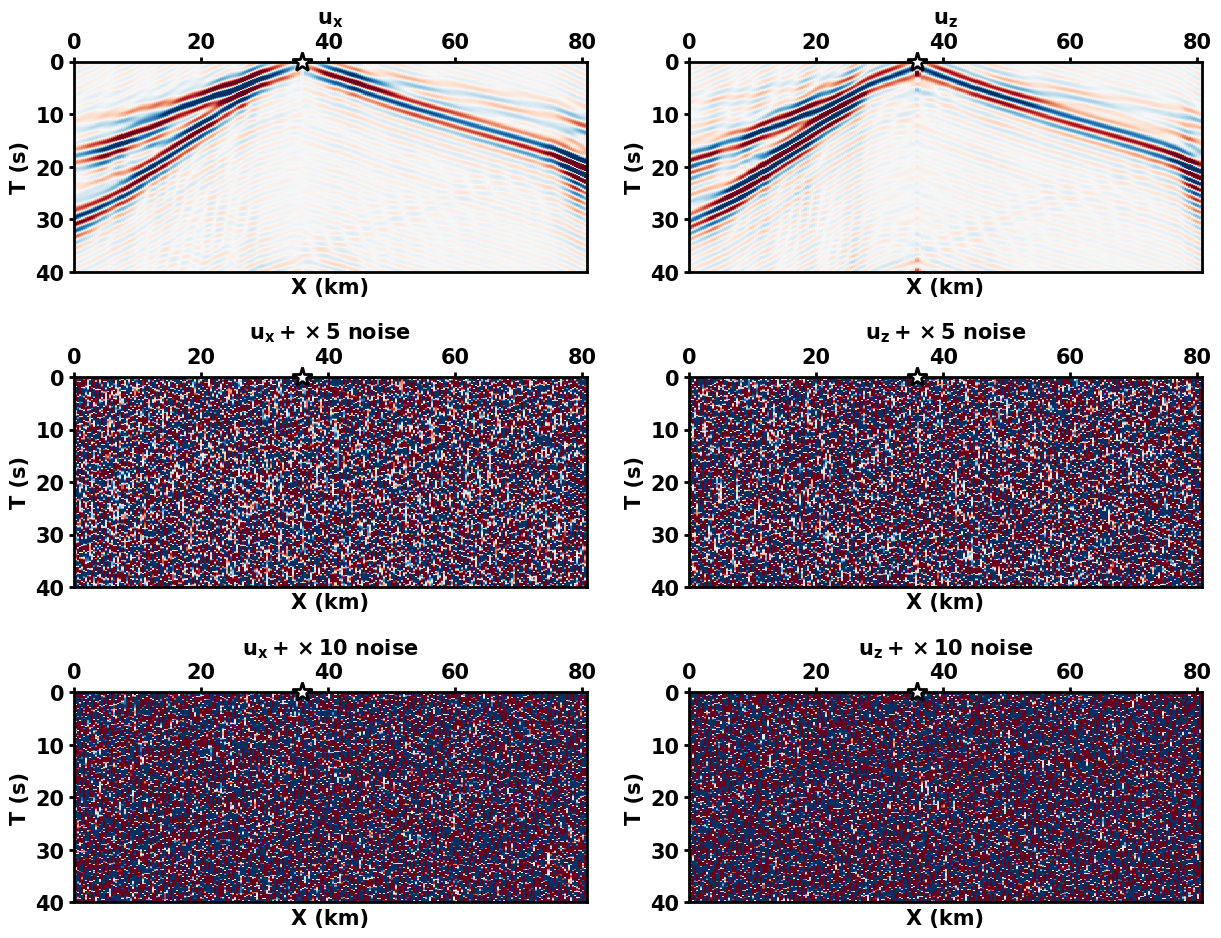

In [7]:
# visualize noise level
i = 100
srcx = test_srcx[i*NF:(i+1)*NF].unique().item()
ori = process.return_to_time(test_out, nt, fs, freqmin, freqmax, depad=pad).squeeze(2)
noi1 = process.return_to_time(process.add_noise(test_out, 5), nt, fs, freqmin, freqmax, depad=pad).squeeze(2)
noi3 = process.return_to_time(process.add_noise(test_out, 10), nt, fs, freqmin, freqmax, depad=pad).squeeze(2)

xt = np.linspace(0, xrange/1000, nx)
t = np.linspace(0, end_time_in_seconds, nt)
xtt, tt = np.meshgrid(xt, t, indexing="ij")

vxmax = np.percentile(ori[i,...,0], 99) 
vzmax = np.percentile(ori[i,...,1], 99) 

fig, axarr = plt.subplots(3, 2, figsize=(12, 9))
fig.tight_layout()
fig.subplots_adjust(hspace=0.5, wspace=0.2)
fig.facecolor = 'white'
plt.rcParams['axes.facecolor'] = 'w'
for ax, data, name, vmax in zip(axarr.flatten(), 
                        [ori[i,...,0], ori[i,...,1],
                         noi1[i,...,0], noi1[i,...,1],
                         noi3[i,...,0], noi3[i,...,1]],
                        ["$\mathregular{u_x}$", "$\mathregular{u_z}$",
                         r'$\mathregular{u_x + \times5}$ noise', r'$\mathregular{u_z + \times5}$ noise',
                         r'$\mathregular{u_x + \times10}$ noise', r'$\mathregular{u_z + \times10}$ noise'],
                            [vxmax, vzmax,
                             vxmax, vzmax,
                             vxmax, vzmax]):
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('bottom')
    ax.invert_yaxis()
    ax.set_title(name, fontsize=15, fontweight='bold')
    ax.tick_params(labelsize=15, width=2)
    ax.set_xlabel("X (km)", fontsize=15, fontweight='bold')
    ax.pcolormesh(xtt, tt, data, 
                vmax=vmax, vmin=-vmax, 
                cmap='RdBu_r', shading='nearest')
    marker = ax.plot(srcx/1000, 0, 'w*', markersize=15, markeredgecolor='k', markeredgewidth=2, zorder=100)
    marker[0].set_clip_on(False)
    ax.set_ylabel("T (s)", fontsize=15, fontweight='bold')
    ax.set_xlim(xtt.min(), xtt.max())
    ax.set_ylim(tt.max(), tt.min())
    
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_weight('bold')
    for spine in ax.spines.values():
        spine.set_linewidth(2)

In [8]:
test_out = process.add_noise(test_out, noise_perc)  # add white noise to data
test_out = test_out[:, recidx, :, :]

In [9]:
assert not torch.isnan(test_out).any()

In [10]:
test_loaders = []
count = 0
for i in range(nstage):
    sub_test_in = []
    sub_test_out = []
    sub_test_srcx = []
    for j in range(0, count+nf_per_stage[i]):  # the jth frequency component
        sub_test_in.append(test_in[j:j+NF*len(srcxs):NF])
        sub_test_out.append(test_out[j:j+NF*len(srcxs):NF])
        sub_test_srcx.append(test_srcx[j:j+NF*len(srcxs):NF])

    sub_test_in = torch.cat(sub_test_in, 0)
    sub_test_out = torch.cat(sub_test_out, 0)
    sub_test_srcx = torch.cat(sub_test_srcx, 0)
    count += nf_per_stage[i]

    test_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(
            sub_test_in,
            sub_test_out, 
            sub_test_srcx),
        batch_size=batch_size,
        shuffle=True)
    
    test_loaders.append(test_loader)

In [11]:
fwi = fwi_wrap.auto_diff_FWI(vs_init=torch.randn(nx, ny), vp_init=torch.randn(nx, ny)).to(device)
fwi.load_state_dict(torch.load("../model/init_1D_syn.pth"))
vp_init = fwi.vp.cpu().detach().numpy()
vs_init = fwi.vs.cpu().detach().numpy()
vp_init = vp_init * (x_standardizer.std[0].item() + x_standardizer.eps) + x_standardizer.mean[0].item()
vs_init = vs_init * (x_standardizer.std[1].item() + x_standardizer.eps) + x_standardizer.mean[1].item()
optimizer = torch.optim.Adam(fwi.parameters(), lr=lr, weight_decay=weight_decay, eps=adameps)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)

In [12]:
xrec = xcoor[recidx]

In [13]:
criterion = torch.nn.MSELoss() 
y_standardizer.cuda()

fwi.train()
model.eval()
istage = 0
for i in tqdm(range(nepoch)):
    if i == np.sum(nepoch_per_stage[:(istage+1)]):
        istage = istage + 1
    
    for x, y, srcx in test_loaders[istage]:
        optimizer.zero_grad() 
        x, y = x.to(device), y.to(device)
        mask = process.get_mask(srcx.squeeze(), xrec, offsetmin, offsetmax)
        out = fwi(x, model)
        y_standardizer.decode(out) 
        y = y[mask]  # (npoint, 1, 4)
        out = out[:, recidx, :, :][mask] # (npoint, 1, 4)
        out, y = process.one_bit_whiten(out), process.one_bit_whiten(y) # (npoint, 1, 4)
        loss = criterion(out, y)
        loss.backward() 

        # smooth gradient
        fwi.vp.grad = torch.from_numpy(gaussian_filter(fwi.vp.grad.cpu(), sigma=sigma_vp)).to(fwi.vp.grad.device)
        fwi.vs.grad = torch.from_numpy(gaussian_filter(fwi.vs.grad.cpu(), sigma=sigma_vs)).to(fwi.vs.grad.device)
        
        optimizer.step()
    
    scheduler.step()
    

100%|██████████| 20/20 [10:03<00:00, 30.15s/it]


In [14]:
torch.save(fwi.state_dict(), "../model/inv_1D_syn_noise{}.pth".format(noise_perc))

In [15]:
vp_inv = fwi.vp.cpu().detach().numpy()
vs_inv = fwi.vs.cpu().detach().numpy()
vp_inv = vp_inv * (x_standardizer.std[0].item() + x_standardizer.eps) + x_standardizer.mean[0].item()
vs_inv = vs_inv * (x_standardizer.std[1].item() + x_standardizer.eps) + x_standardizer.mean[1].item()

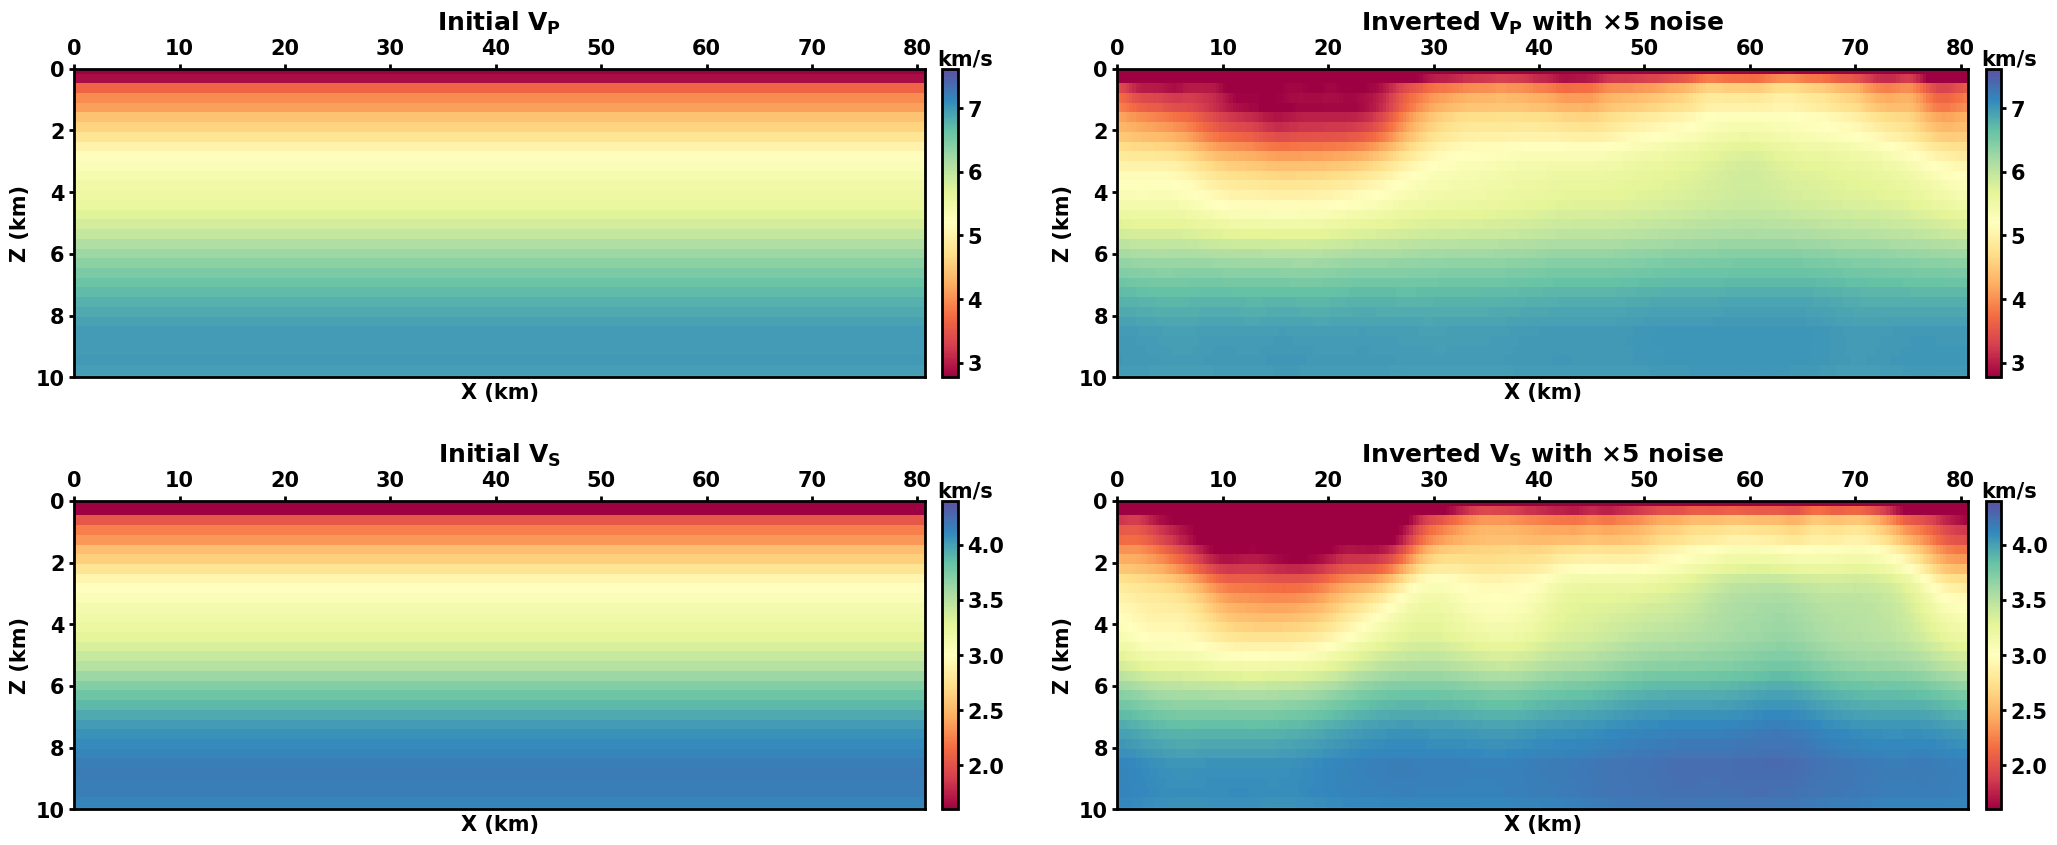

In [16]:
zcut = 10000
jcut = np.argmin(np.abs(ycoor-zcut)) + 1
figplot.plot_fwi_result(vp_init[:, :jcut], vp_inv[:, :jcut], vs_init[:, :jcut], vs_inv[:, :jcut], xrange, ycoor[jcut-1], nx, jcut, y1=10,
                        name2=rf'Inverted $\mathregular{{V_P}}$ with $\mathregular{{\times{noise_perc}}}$ noise', 
                        name4=rf'Inverted $\mathregular{{V_S}}$ with $\mathregular{{\times{noise_perc}}}$ noise')